# Thoracic Surgery Life Expectancy Classification

In [3]:
%%capture
!pip install seaborn
!pip install xgboost
!pip install dexplot

In [203]:
# loading dataset
from scipy.io import arff
import urllib.request
from io import StringIO
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import dexplot as dxp
from scipy.interpolate import interp1d

# pre-processing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# parameter tuning
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, recall_score, precision_score

## Loading the Dataset

In [5]:
# download dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00277/ThoraricSurgery.arff"
ftpstream = urllib.request.urlopen(url)
data, meta = arff.loadarff(StringIO(ftpstream.read().decode('utf-8')))
df = pd.DataFrame(data)

# strip vaues according to utf-8 encoding 
df = df.select_dtypes([np.object])
df = df.stack().str.decode('utf-8').unstack()

In [6]:
df.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


## Dataset Overview

### Check that there are no missing values

In [8]:
df.notnull().describe()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,True,True,True,True,True,True,True,True,True,True,True,True,True,True
freq,470,470,470,470,470,470,470,470,470,470,470,470,470,470


The table returns True for each value found, and this table is entirely composed of True values (top: True, unique: 1), which means that there are no null values in the dataset.

Now we want to check that the parameter that should only allow binary values (corresponding to true or false), actually hold maximim 2 values.

In [7]:
desc = df.describe() # saving it to use it during visualisation
desc

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,Risk1Yr
count,470,470,470,470,470,470,470,470,470,470,470,470,470,470
unique,7,3,2,2,2,2,2,4,2,2,2,2,2,2
top,DGN3,PRZ1,F,F,F,T,F,OC12,F,F,F,T,F,F
freq,349,313,439,402,439,323,392,257,435,468,462,386,468,400


We can see from the description of the dataset that all parameters that should allow (T)rue or (F)alse values (columns: PRE7, PRE8, PRE9, PRE10, PRE11, PRE17, PRE19, PRE25, PRE30, PRE32, Risk1Yr), only have 2 unique values, which confirms that no missing value has been substituted with another character or string of characters (such as '?' or 'NA'). 

### Visualise data

It would be interesting to visualise how each of the pre-existing conditions, i.e. features, influences the mortality of the surgical operation. To do so, we can divide the dataset into two, according to whether the patients associated to each sample survived or not after the surgery.

In [9]:
df_surv = df.loc[df["Risk1Yr"] == 'F']
df_died = df.loc[df["Risk1Yr"] == 'T']

# list of features as it appears in the official online description of the dataset
# features that are not present in the downloaded dataset were commented out
features = dict(DGN =   'Diagnosis',
        #PRE4 =	'Forced vital capacity',
        #PRE5 =	'Volume that has been exhaled at the end of the first second of forced expiration',
        PRE6 =	'Performance status - Zubrod scale',
        PRE7 =	'Pain before surgery',
        PRE8 =  'Haemoptysis before surgery',
        PRE9 =	'Dyspnoea before surgery',
        PRE10 =	'Cough before surgery',
        PRE11 = 'Weakness before surgery',
        PRE14 = 'size of the original tumour',
        PRE17 = 'Type 2 DM - diabetes mellitus',
        PRE19 = 'MI up to 6 months',
        PRE25 = 'PAD - peripheral arterial diseases',
        PRE30 = 'Smoking',
        PRE32 = 'Asthma',
        #AGE =  'Age at surgery'
        )

Once we have the two separated datasets, we can plot a histogram for each feature, showing how many survivors and how many deceased patients compose each value of each feature, e.g. how many of the people with the feature 'PRE17' (diabetes) survived and how many died).

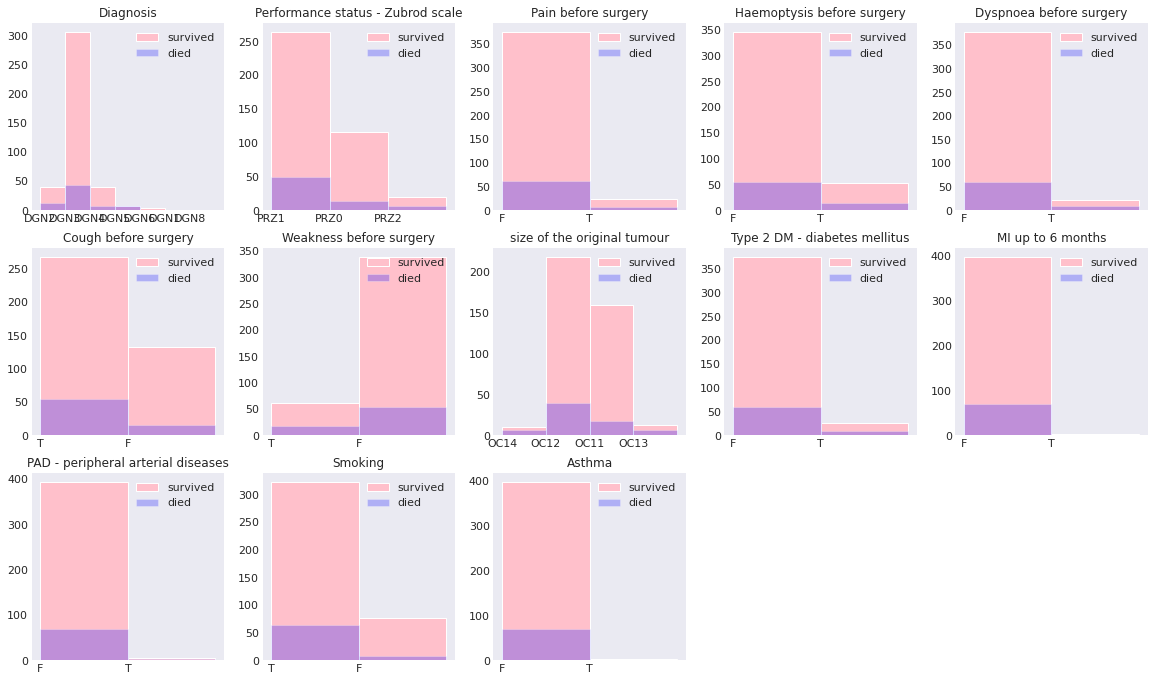

In [311]:
fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
plt.style.use('seaborn-dark')

for k,v in features.items():
    c += 1
    val = list(desc[k])[1] # possible values for each column
    chart = fig.add_subplot(5,5,c)
    chart.title.set_text(v)
    
    bins = np.linspace(0, val, num=val+1)

    surv = df_surv[k]
    died = df_died[k]

    chart.hist(surv , bins, alpha=1, color='pink', label='survived', rwidth=6)
    chart.hist(died , bins, alpha=0.25, color='blue', label='died', rwidth=6)

    plt.legend(loc='upper right')

plt.show()

Unfortunately, since most features seem to be unbalanced in the number of samples for each of their values (the ratio of patients with PAD or asthma is very low, for example), normalisation needs to be applied in order to se the density of fataliites for each features.

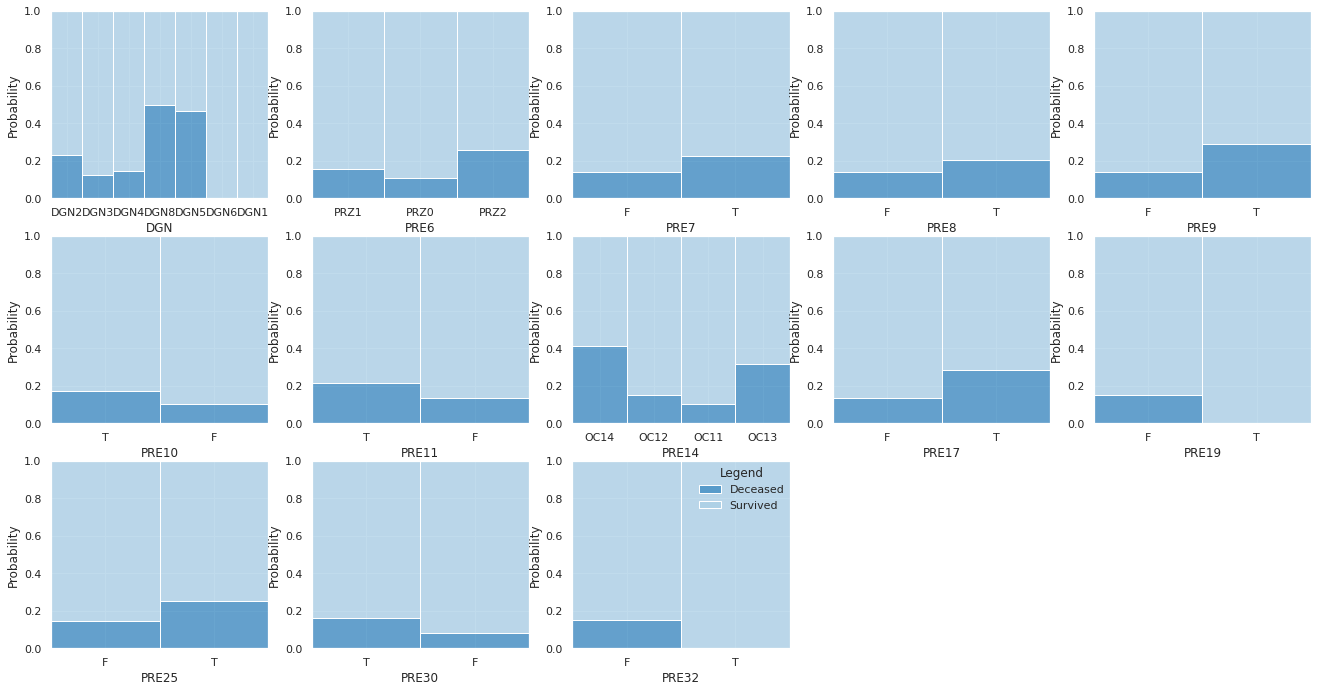

In [338]:
fig = plt.figure(1, figsize=(20.0,20.0))
c = 0
for k,v in features.items():
    c += 1
    chart = fig.add_subplot(5,5,c)
    sns.set(font_scale=1)
    sns.histplot(df, x=k, hue="Risk1Yr", stat="probability", multiple="fill",
                            palette='Blues', legend=False)

plt.legend(labels=['Deceased', 'Survived'],
            loc="upper right",
            borderaxespad=0.1,
            title="Legend")

plt.subplots_adjust(right=1)
plt.show()

## Preprocessing

In [12]:
df.shape

(470, 14)

In [13]:
target = df.Risk1Yr
target.shape

(470,)

In [14]:
labels = np.reshape(target.values,(470,1))
labels.shape

(470, 1)

In [15]:
feature_ds = np.concatenate([df.iloc[:,:-1], labels], axis=1)
feature_ds.shape

(470, 14)

In [16]:
ds = pd.DataFrame(feature_ds)
ds.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


In [17]:
ds.columns = ['DGN', 'PRE6', 'PRE7', 'PRE8', 'PRE9', 'PRE10', 'PRE11', 'PRE14', 'PRE17', 'PRE19', 'PRE25', 'PRE30', 'PRE32', 'label']
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,F
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,F
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,F
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,F
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,T


In [18]:
ds['label'].replace('F', 'Survived',inplace=True)
ds['label'].replace('T', 'Died',inplace=True)
ds.head()

,DGN,PRE6,PRE7,PRE8,PRE9,PRE10,PRE11,PRE14,PRE17,PRE19,PRE25,PRE30,PRE32,label
0,DGN2,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,Survived
1,DGN3,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,Survived
2,DGN3,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,Survived
3,DGN3,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,Survived
4,DGN3,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,Died


In [19]:
ohe = OneHotEncoder()
ds_e = pd.DataFrame(ohe.fit_transform(ds.to_numpy()).toarray())
ds_e.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [20]:
sum(ds.describe().iloc[1,]) == len(ds_e.columns) # to check the possible feature values correspond to the number of columns

True

### Shuffle and split data into features X and target y.

In [21]:
ds_er = ds_e.sample(frac=1)

X = ds_er.iloc[:,:-2]
y = ds_er.iloc[:,-1]

## Algorithm

In [22]:
# splitting train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

### Define the baselines

In [24]:
rs = 5

In [25]:
%%capture
models = [LogisticRegression(random_state=rs),
          MultinomialNB(),
          KNeighborsClassifier(),
          SVC(random_state=rs),
          LinearSVC(random_state=rs),
          DecisionTreeClassifier(random_state=rs),
          RandomForestClassifier(random_state=rs),
          GradientBoostingClassifier(random_state=rs),
          XGBClassifier(random_state=rs)]

model = []
mean = []
std = []
mins = []
maxs = []

for m in models:
    cross = cross_val_score(m, X_train, y_train, cv=5)
    model.append(type(m).__name__)
    mean.append(cross.mean())
    std.append(cross.std())
    mins.append(min(cross))
    maxs.append(max(cross))

In [26]:
result = pd.DataFrame({"Model":model, "acc_mean":mean, "STD":std, "min":mins, "max":maxs})
result.sort_values("acc_mean", ascending=False)

,Model,acc_mean,STD,min,max
3,SVC,0.851096,0.005221,0.848485,0.861538
2,KNeighborsClassifier,0.851049,0.006358,0.846154,0.863636
0,LogisticRegression,0.841958,0.015296,0.818182,0.863636
4,LinearSVC,0.832821,0.016629,0.818182,0.863636
1,MultinomialNB,0.823776,0.022192,0.787879,0.848485
7,GradientBoostingClassifier,0.814685,0.023611,0.787879,0.846154
8,XGBClassifier,0.814639,0.017164,0.787879,0.833333
6,RandomForestClassifier,0.814639,0.014240,0.803030,0.833333
5,DecisionTreeClassifier,0.802471,0.031534,0.742424,0.833333


### Improve parameters of the best performing model

In [27]:
pipeline.get_params().keys()

NameError: name 'pipeline' is not defined

In [36]:
# creating pipeline
pipeline = Pipeline([('classifier', SVC())])
#pipeline = Pipeline([('classifier', KNeighborsClassifier())])
#pipeline = Pipeline([('classifier', LinearSVC())])

In [37]:
# defining parameter range
#SVC
params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
'''
# KNN
k_range = list(range(1, 31))
params = param_grid = dict(n_neighbors=k_range)

# LinearSVC
params = {'C': [0.1, 1, 10, 100, 1000]}
'''

"\n# KNN\nk_range = list(range(1, 31))\nparams = param_grid = dict(n_neighbors=k_range)\n\n# LinearSVC\nparams = {'C': [0.1, 1, 10, 100, 1000]}\n"

In [55]:
%%capture
# grid search
grid = GridSearchCV(SVC(probability=True), param_grid=params, refit = True, verbose = 3, cv=5) #SVC
#grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=10, scoring='accuracy') #KNN
#grid = GridSearchCV(LinearSVC(),param_grid=params,cv=5,return_train_score=True) # LinearSVC

In [56]:
%%capture
# fitting the model for grid search
grid.fit(X_train, y_train)

In [57]:
grid.best_estimator_
grid.best_score_

0.8510955710955711

## Test Results

In [58]:
# predicting over test set
y_pred = grid.predict(X_test)

In [142]:
# predicting probabilities over test set
y_pred_prob = grid.predict_proba(X_test)

[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

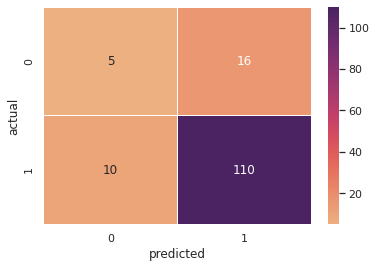

In [171]:
# plotting confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        21
         1.0       0.85      1.00      0.92       120

    accuracy                           0.85       141
   macro avg       0.43      0.50      0.46       141
weighted avg       0.72      0.85      0.78       141

/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisa

In [271]:
%%capture
i = np.argsort(y_pred_prob[:,0])[::-1]
prob = y_pred_prob[i][:,0]
test_labels = y_test.iloc[i].tolist()
list(zip(prob, test_labels))

/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


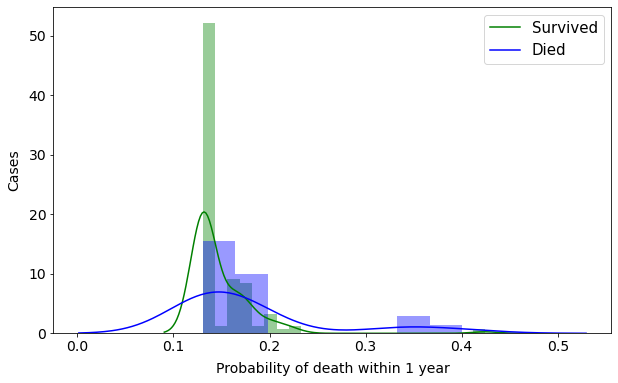

In [141]:
plt.figure(figsize=(10, 6))

plt.ylabel('Cases', fontsize=14, labelpad=7.5)
plt.xlabel('Probability of death within 1 year', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(y_pred_prob[y_test == 1.0][:,0], color='green')
sns.distplot(y_pred_prob[y_test == 0.0][:,0], color='blue')

plt.legend(labels=['Survived', 'Died'], fontsize=15)

plt.show()


## Ablation study
How the system behaves when canging the weights and the scoring funnction

In [220]:
def scoring_function(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0) + f1_score(y_true, y_pred, pos_label=1) 

In [273]:
weights_d = np.arange(1,8,0.5)

In [281]:
%%capture
conf = []
for weight_d in weights_d:
     grid = GridSearchCV(SVC(probability=True, class_weight={0.0:weight_d, 1.0:1}), param_grid=params,      refit = True, verbose = 3, cv=5, scoring=make_scorer(scoring_function))
     grid.fit(X_train, y_train)
     y_pred = grid.predict(X_test)
     y_pred_prob = grid.predict_proba(X_test)
     conf.append(confusion_matrix(y_test, y_pred))

In [275]:
conf=np.array(conf)
true_died = conf[:,0,0]
true_surv = conf[:,1,1]
false_died = conf[:,1,0]
false_surv = conf[:,0,1]

/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

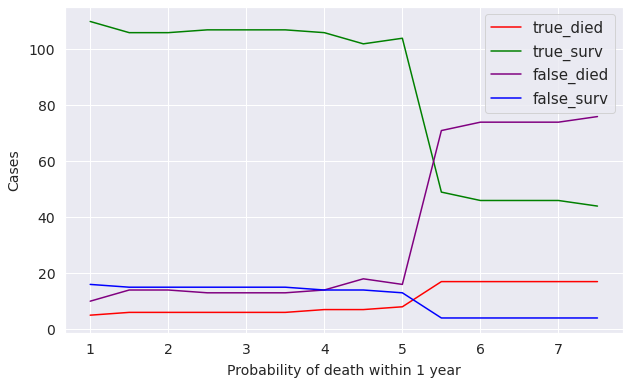

In [276]:
plt.figure(figsize=(10, 6))

plt.ylabel('Cases', fontsize=14, labelpad=7.5)
plt.xlabel('Probability of death within 1 year', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.lineplot(weights_d, true_died, color='red')
sns.lineplot(weights_d, true_surv, color='green')
sns.lineplot(weights_d, false_died, color='purple')
sns.lineplot(weights_d, false_surv, color='blue')

plt.legend(labels=['true_died', 'true_surv', 'false_died', 'false_surv'], fontsize=15)

plt.show()


[Text(0.5, 12.5, 'predicted'), Text(30.5, 0.5, 'actual')]

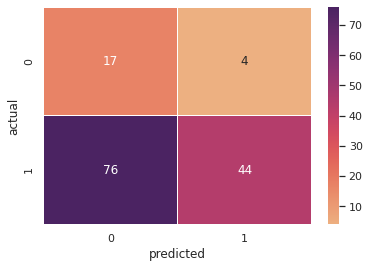

In [277]:
# plotting confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1)
matrix = sns.heatmap(conf_mat, annot=True, fmt='d', linewidths=.5, cmap='flare')
matrix.set(xlabel='predicted', ylabel='actual')

In [278]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.18      0.81      0.30        21
         1.0       0.92      0.37      0.52       120

    accuracy                           0.43       141
   macro avg       0.55      0.59      0.41       141
weighted avg       0.81      0.43      0.49       141



In [279]:
%%capture
i = np.argsort(y_pred_prob[:,0])[::-1]
prob = y_pred_prob[i][:,0]
test_labels = y_test.iloc[i].tolist()
list(zip(prob, test_labels))

/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/elisa/github/UL-labs/env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


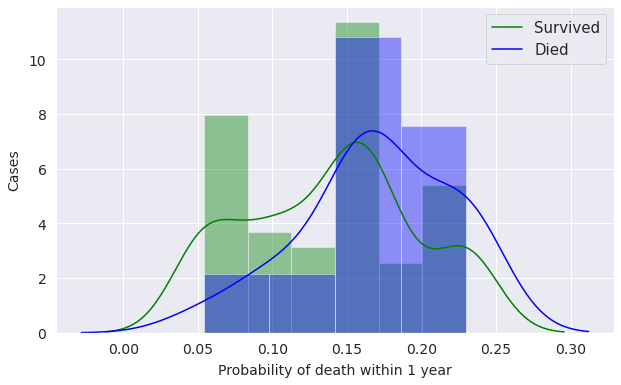

In [280]:
plt.figure(figsize=(10, 6))

plt.ylabel('Cases', fontsize=14, labelpad=7.5)
plt.xlabel('Probability of death within 1 year', fontsize=14, labelpad=7.5)
plt.xticks(fontsize=14) 
plt.yticks(fontsize=14)

sns.distplot(y_pred_prob[y_test == 1.0][:,0], color='green')
sns.distplot(y_pred_prob[y_test == 0.0][:,0], color='blue')

plt.legend(labels=['Survived', 'Died'], fontsize=15)

plt.show()
